# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Necessary Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2
72460,13,Janis Martin,", 75, American opera singer.",https://en.wikipedia.org/wiki/Janis_Martin_(soprano),7,2014,December,None,None,opera singer,None,None,None,None,None,None,None,None,None,75.0,None,United States of America,None,None
39338,30,Mike Francis,", 47, Italian pop musician, lung cancer.",https://en.wikipedia.org/wiki/Mike_Francis,5,2009,January,None,None,pop musician,lung cancer,None,None,None,None,None,None,None,None,47.0,None,Italy,None,None
103483,27,Laurie Hendren,", 60, Canadian computer scientist, cancer.",https://en.wikipedia.org/wiki/Laurie_Hendren,15,2019,May,None,None,computer scientist,cancer,None,None,None,None,None,None,None,None,60.0,None,Canada,None,None
45098,25,Alan Hickinbotham,", 84, Australian football player and businessman.",https://en.wikipedia.org/wiki/Alan_Hickinbotham,6,2010,May,None,None,football player businessman,None,None,None,None,None,None,None,None,None,84.0,None,Australia,None,None
62420,26,"Rawleigh Warner, Jr.",", 92, American oil executive, CEO and Chairman of Mobil , inclusion body myositis.","https://en.wikipedia.org/wiki/Rawleigh_Warner,_Jr.",13,2013,June,,None,oil executive,CEO Chairman of Mobil,inclusion body myositis,None,None,None,None,None,None,None,92.0,None,United States of America,None,1969 1986


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   day             132652 non-null  object 
 1   name            132652 non-null  object 
 2   info            132652 non-null  object 
 3   link            132652 non-null  object 
 4   num_references  132652 non-null  object 
 5   year            132652 non-null  int64  
 6   month           132652 non-null  object 
 7   info_parenth    49830 non-null   object 
 8   info_1          35 non-null      object 
 9   info_2          132604 non-null  object 
 10  info_3          62571 non-null   object 
 11  info_4          12605 non-null   object 
 12  info_5          1497 non-null    object 
 13  info_6          216 non-null     object 
 14  info_7          31 non-null      object 
 15  info_8          6 non-null       object 
 16  info_9          1 non-null       object 
 17  info_10   

<IPython.core.display.Javascript object>

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [6]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

#### Loading `nation_map` from Pickle File to Dictionary nation_map

In [7]:
# Load the nation_map
with open("nation_map.pkl", "rb") as f:
    nation_map = pickle.load(f)

<IPython.core.display.Javascript object>

#### Loading `other_species` list from other_species.csv

In [8]:
# Loading other_species list
other_species_df = pd.read_csv("other_species.csv")
other_species = other_species_df["species"].tolist()
other_species = list(
    set(other_species)
)  # To avoid searching duplicates as we have been adding back to same csv file

<IPython.core.display.Javascript object>

### `num_references`

In [9]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

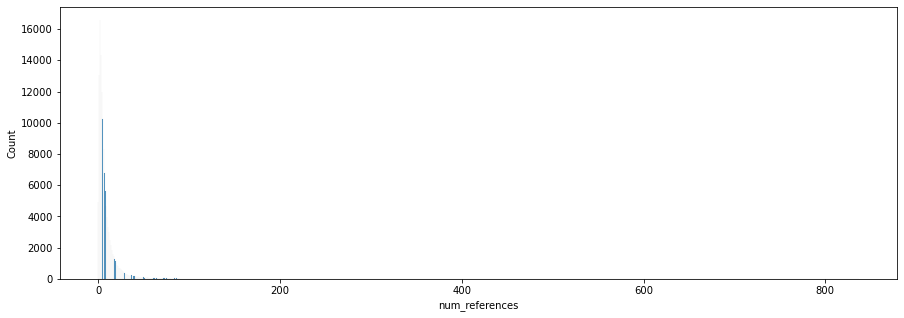

<IPython.core.display.Javascript object>

In [10]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [11]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since House of Representatives,None,politician Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,Prime Minister,None,revolutionary politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [12]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [13]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

In [14]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
]

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 Where Entry Link Points to a List Page

In [15]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2
58529,11,Alois Schnaubelt,", 91, German Nazi soldier, awarded Knight's Cross of the Iron Cross .",https://en.wikipedia.org/wiki/Alois_Schnaubelt,1,2012,December,,None,soldier,awarded Knight Cross of the Iron Cross,None,None,None,None,None,None,None,None,91.0,None,Germany,Germany,1944
65786,6,Herbert Fries,", 88, German Oberfähnrich in the Fallschirmjäger during World War II.",https://en.wikipedia.org/wiki/Herbert_Fries,1,2014,January,None,None,Oberfähnrich in the Fallschirmjäger during World War II,None,None,None,None,None,None,None,None,None,88.0,None,Germany,None,None


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [16]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.736016
std          19.066372
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

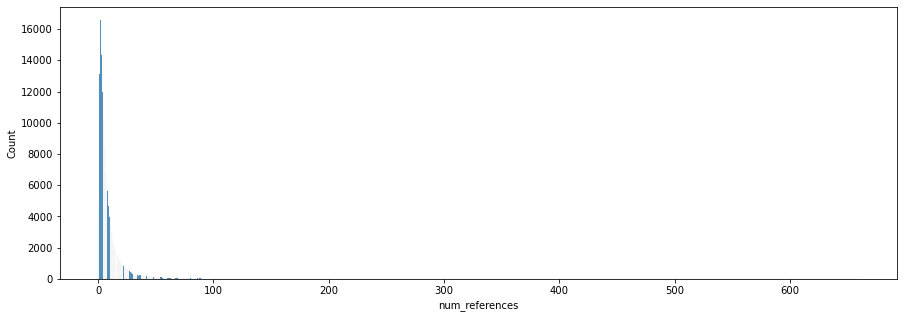

<IPython.core.display.Javascript object>

In [17]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

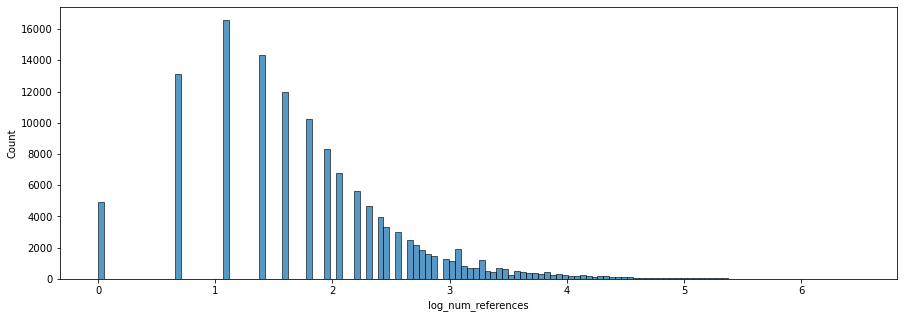

<IPython.core.display.Javascript object>

In [18]:
# Adding column for log_num_references
df["log_num_references"] = np.log(df["num_references"] + 1)

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

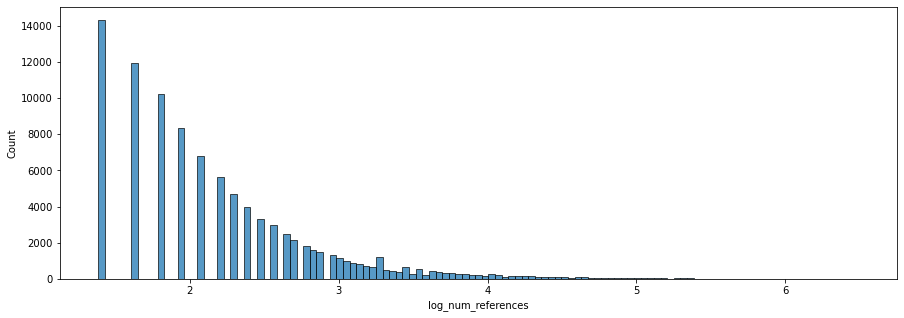

<IPython.core.display.Javascript object>

In [19]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.
- We can keep the full dataset intact at this point, but rely on these entries to create a dictionary for extracting `known_for` values.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.  Later, when there are duplicate categories for an indivual, we can remove the redundant values.

We will take the following approach:
1. create and check a list of unique values in `info_2` that have a minimum number repeated, sufficient to create sets for each category, but not so exhaustive to be time prohibitive to manually enter.
2. using the pop() method, add each role to it's associated category's set, below.
3. combine the sets for each category into one dictionary.
4. search for the values in the dictionary and extract the category key value to a new column `known_for_1`, `known_for_2`, etc.

In [53]:
# Obtaining values for column and their counts
col_values = df[df["num_references"] > 2]["info_2"].value_counts()

# Creating a list for values that occur more than set number of times
roles_list = [index for index in col_values.index if col_values[index] > 20]

# Checking length of list
print(f"We will examine the top {len(roles_list)} unique values in info_2.")

We will examine the top 488 unique values in info_2.


<IPython.core.display.Javascript object>

In [354]:
len(roles_list)

192

<IPython.core.display.Javascript object>

In [381]:
# Using pop to check list items and add to associated dictionary below
roles_list.pop()

'criminal'

<IPython.core.display.Javascript object>

In [ ]:
# Creating lists for each category
politics_govt_law = [
    'retired lawyer Justice Department official known for prosecution of alleged war criminals',
    'prosecutor for war criminals',
    'criminal defense',
    'politic',
    'princess',
    'lawyer',
    'attorney',
    'judge',
    'Justice',
    'justice',
    'solicitor',
    'jurist',
    'jury',
    'juror',
    'econom',
    'barrister',
    'conservationis',
    'govern',
    'peer',
    'environmentalis',
    'human rights',
    'rights',
    'activist',
    'aristocrat',
    'diploma'
    

]

arts = [
    'gospel',
    'producer',
    'disc jockey',
    'film director',
    'designer',
    'science fiction writer',
    'science fiction author',
    'author',
    'screen',
    'writer',
    'bluegrass',
    'musician',
    'drama',
    'novelist',
    'journalist',
    'broadcaster',
    'conductor',
    'composer',
    'rock',
    'guitar',
    'actress',
    'actor',
    'model',
    'poet',
    'playwright',
    'puppet',
    'television director'
    'television',
    'TV',
    'host',
    'sculpt',
    'paint',
    'sing',
    'song',
    'radio'
    'presenter',
    'printmaker',
    'potter',
    'reggae',
    'music producer',
    'art dealer',
    'winemaker', 
    'artist',
    'blues',
    'country singer',
    'country music',
    'jazz',
    'pian',
    'choreograph',
    'translator',
    'film',
    'magic',
    'news',
    'anchor',
    'tenor',
    'comic',
    'book',
    'trombon'
    'voice',
    'critic',
    'bass',
    'editor',
    'document',
    'opera',
    'tenor',
    'organist',
    'keyboard',
    'manga',
    'playback',
    'folk',
    'balle',
    'personality',
    'model',
    'costume',
    'cellist',
    'cello',
    'lyric',
    'soul',
    'soprano',
    'visual',
    'comed',
    'illustrat',
    'R&B',
    'chef',
    'literary',
    'theatre director',
    'theater director',
    'theatre',
    'theater',
    'saxophon,
    'graphic',
    'character',
    'trumpet',
    'pop '

    
    
    
    

]
sports = [
    'jockey',
    'martial artist'
    'sports administrator',
    'sports'
    'basketball',
    "NBA",
    'baseball', 
    'MLB',
    'handball',
    'cross country',
    'skier',
    'weightlift',
    'football',
    'Olymp',
    'gymnast',
    'olymp',
    'paralymp',
    'Paralymp',
    'hockey',
    'speedway',
    'rider',
    'chess',
    'runn'
    'cricket',
    'umpire',
    'track',
    'field',
    'athlet',
    'racecar',
    'driver',
    'wrestl',
    'badminton',
    'bodybuild',
    'racehorse trainer',
    'racing',
    'cylci',
    'race car',
    'judo',
    'curl',
    'Baseball',
    'bridge player',
    'long distance',
    'distance',
    'sail',
    'sumo',
    'skate',
    'golf',
    'sprint',
    'tennis',
    'fencer',
    'fencing',
    'referee',
    'motorcycle',
    'rower',
    'rowing',
    'mountain',
    'rugby league',
    'rugby',
    'Rugby',
    
    
    
    

    
    

    
    
    
    

]
sciences = [
    'game designer',
    'molecular',
    'biolog',
    'doctor',
    'psycholog',
    'paleontolog',
    'neurologist',
    'pathologist',
    'psychoanalys',
    'organic chemist',
    'chemist',
    'aeronautic',
    'engineer',
    'pharmacolog',
    'geophysi',
    'virolo
    'neurosurg',
    'entomolog',
    'pediatric',
    'astronaut',
    'cardiolog',
    'physician',
    'nurs',
    'immunolog',
    'meteorolog',
    'ornitholog',
    'medical',
    'zoolog',
    'neuroscientist',
    'geograph',
    'statistic',
    'inventor',
    'genetic',
    'astrophysic',
    'surgeon',
    
    
    
]

business = [
    'advertising executive',
    'executive',
    'financier',
    'real estate developer',
    'real estate',
    'mogul',
    'restaurant',
    'businesswoman',
    'businessman',
    'business',
    'trade unionist',
    'unionist',
    'industrialist'
    
    
    
]
academia_humanities = [
    'academic administrator',
    'legal scholar',
    'literary scholar',
    'educat',
    'academ',
    'schol',
    'historian',
    'teacher',
    'philolog',
    'librar',
    'professor',
    'Professor',
    'musicologist'
    
    

]
law_enf_military_operator = [
    'officer',
    'air force',
    'Air Force',
    'Navy',
    'navy',
    'naval',
    'admiral',
    'Admiral',
    'marshal',
    'general',
    'lieutenant',
    'veteran',
    'Veteran',
    'intelligence',
    'Army',
    'army',
    'major',
    'militant',
    'pilot',
    'aviat',
    'informant'
]
spiritual = [
    'prelate',
    'pastor',
    'Buddh', 
    'monk',
    'buddh',
    'Jesuit',
    'priest',
    'Episcopal',
    'Anglican',
    'bishop',
    'Bishop',
    'Islamic scholar',
    'religious leader'
    
]
social = ['social worker','socialite']
# 'terrorist' will need separate treatment
crime = [
    'war criminal',
    'criminal'
    'criminal',
    'murderer',
    'mobster',
]
event_record_other = ['student', 'survivor', 'supercentenarian', ]
other_species = other_species + []

In [141]:
other_species

['racing filly',
 'fish',
 'carp',
 'colt',
 'tortoise',
 'dog',
 'racehorse',
 'cat',
 'bear',
 'kiwi',
 'alligator',
 'wolf',
 'gorilla',
 'triple crown winner',
 'mammal',
 'race horse',
 'orca',
 'bird',
 'tree',
 'Thoroughbred hurdler',
 'horse',
 'turkey',
 'flamingo',
 'stallion',
 'chimpanzee']

<IPython.core.display.Javascript object>

In [382]:
df.loc[[index for index in df.index if "criminal" in df.loc[index, "info"]], :]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_2,log_num_references
29,5,Franz Murer,", 81, Austrian SS officer and war criminal.",https://en.wikipedia.org/wiki/Franz_Murer,8,1994,January,None,None,SS officer war criminal,None,None,None,None,None,None,None,None,None,81.0,None,Austria,None,None,2.197225
1124,22,Otto Bradfisch,", 91, German SS-Obersturmbannführer and war criminal during World War II.",https://en.wikipedia.org/wiki/Otto_Bradfisch,0,1994,June,None,None,SS Obersturmbannführer war criminal during World War II,None,None,None,None,None,None,None,None,None,91.0,None,Germany,None,None,0.000000
1275,18,Michele Zaza,", 49, Italian member of the Camorra criminal organisation, heart attack.",https://en.wikipedia.org/wiki/Michele_Zaza,25,1994,July,None,None,member of the Camorra criminal organisation,heart attack,None,None,None,None,None,None,None,None,49.0,None,Italy,None,None,3.258097
1456,18,Martin Cahill,", 45, Irish criminal, homicide.",https://en.wikipedia.org/wiki/Martin_Cahill,22,1994,August,None,None,criminal,homicide,None,None,None,None,None,None,None,None,45.0,None,Ireland,None,None,3.135494
1472,20,Hermann Hackmann,", 80, German war criminal and SS captain during World War II.",https://en.wikipedia.org/wiki/Hermann_Hackmann,4,1994,August,None,None,war criminal SS captain during World War II,None,None,None,None,None,None,None,None,None,80.0,None,Germany,None,None,1.609438
2090,28,Buster Edwards,", 63, British criminal, suicide.",https://en.wikipedia.org/wiki/Buster_Edwards,8,1994,November,None,None,criminal,suicide,None,None,None,None,None,None,None,None,63.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,2.197225
2949,17,Ronnie Kray,", 61, British criminal and twin brother of Reggie Kray, heart attack.",https://en.wikipedia.org/wiki/Kray_twins,70,1995,March,None,None,criminal twin brother of Reggie Kray,heart attack,None,None,None,None,None,None,None,None,61.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,4.262680
3265,27,Auto Shankar,", 41, Indian criminal and gangster, suicide.",https://en.wikipedia.org/wiki/Auto_Shankar,12,1995,April,None,None,criminal gangster,suicide,None,None,None,None,None,None,None,None,41.0,None,India,None,None,2.564949
3878,18,Ryōichi Sasakawa,", 96, Japanese suspected war criminal, businessman, politician, and philanthropist.",https://en.wikipedia.org/wiki/Ry%C5%8Dichi_Sasakawa,45,1995,July,None,None,suspected war criminal,businessman,politician,and philanthropist,None,None,None,None,None,None,96.0,None,Japan,None,None,3.828641
6718,2,Karl Frenzel,", 85, German Nazi war criminal.",https://en.wikipedia.org/wiki/Karl_Frenzel,18,1996,September,None,None,war criminal,None,None,None,None,None,None,None,None,None,85.0,None,Germany,Germany,None,2.944439


<IPython.core.display.Javascript object>

In [ ]:
# Creating lists for each category
politics_govt_law = [
    "politic",
    "attorney",
    "Attorney",
    "unionist",
    "aristocrat",
    "diplomat",
    "lawyer",
    "activis",
    "rights",
    "federal",
    "judge",
    "royal",
    "civil",
    "jurist",
    "juror",
    "jury",
    "judge",
    "conserv",
    "govern",
    "barrister",
    "environmental",
    "King",
    "Queen",
    "Prince",
    "President",
    "Prime Minister",
    "leader",
    "Nazi",
    "Administrat",
    "Ambassador",
    "ambassador",
    "Econom",
]

arts = [
    "actor",
    "actress",
    "acting",
    "artist",
    "dance",
    "choreograph",
    "model",
    "televis",
    "jazz",
    "sing",
    "compose",
    "conduct",
    "journal",
    "write",
    "saxophon",
    "film",
    "comed",
    "poet",
    "edit",
    "drum",
    "produce",
    "song",
    "publish",
    "author",
    "violin",
    "rapper",
    "music",
    "animat",
    "pian",
    "comic",
    "fashion",
    "design",
    "guitar",
    "voice",
    "opera",
    "cinema",
    "playwright",
    "sculpt",
    "novel",
    "photo",
    "architect",
    "paint",
    "disc jockey",
    "MC",
    "bridge",
    "tenor",
    "trombon",
    "balle",
    "bass",
    "critic",
    "personality",
    "organist",
    "pipe organ",
    "lyric",
    "translat",
    "soprano",
    "cell",
    "broadcast",
    "chef",
    "literary",
    "illustrat",
    "theat",
    "trumpet",
    "present",
    "sportscast",
    "cartoon",
    "sportswriter",
    "choral",
    "Choral",
    'screen',
    'musician',
    ''
]
sports = [
    "footbal",
    "Olympic",
    "hockey",
    "soccer",
    "cricket",
    "sprint",
    "equestrian",
    "gymnast",
    "fenc",
    "chess",
    "wrestl",
    "swim",
    "basketball",
    "hurl",
    "sail",
    "row",
    "rugby",
    "Rugby",
    "athlet",
    "golf",
    "boxing",
    "boxer",
    "tennis",
    "cycli",
    "racing",
    "driver",
    "baseball",
    "rider",
    "speedway",
    "badminton",
    "sport shoot",
    "runner",
    "running",
    "umpire",
    "judoka",
    "volleyball",
    "track",
    "field",
    "bobsled",
    "canoe",
    "bodybuild",
    "skate",
    "curler",
    "curling" "Olympic div",
    "martial artist",
    "racer",
    "handball",
    "jumper",
    "racehorse trainer",
    "racecar driver",
    "hurdle",
    "polo",
    "Olympic shooter",
    "weightlift",
    "Baseball",
    "mountain",
    "jockey",
    "Olympic sports shooter",
    "referee",
    "general manager",
    "sport",
    "athlet",
    "NFL",
    "NHL",
    "MLB",
]
sciences = [
    "engineer",
    "physic",
    "geolog",
    "psychiatr",
    "botan",
    "biolog",
    "anthrop",
    "astron",
    "chemist",
    "scientist",
    "compute",
    "programm",
    "archaeolog",
    "psycholog",
    "sociolog",
    "math",
    "cosmonaut",
    "pediatric",
    "astron",
    "entomolog",
    "cardiolog",
    "doctor",
    "nurs",
    "immunolog",
    "meteorolog",
    "medical researcher",
    "medical",
    "medicine",
    "ornithol",
    "scientist",
    "zoolog",
    "geogr",
    "inventor",
    "genetic",
    "surgeon",
    "statistic",
    "science",
    "epidemiolog",
]

business = [
    "executive",
    "business",
    "bank",
    "entrepren",
    "real estate developer",
    "real estate",
    "restaurateur",
    "sports administrat",
    "industr",
]
academia_humanities = [
    "schol",
    "lingu",
    "educat",
    "philosoph",
    "academi",
    "military historian",
    "histor",
    "philolog",
    "librar",
    "profess",
    "Profess",
    "musicologist",
    "college",
    "university",
    "humanit",
    "professor",
    "Professor",
]
law_enf_military_operator = [
    "officer",
    "army",
    "Army",
    "police",
    "Police",
    "admiral",
    "soldier",
    "Air Force",
    "intelligence",
    "major",
    "Major",
    "lieutenant",
    "admiral",
    "pilot",
    "naval",
    "navy",
    "Navy",
    "aviat",
    "general",
    "CIA",
    "FBI",
    "law enforce",
    "milit",
    "Marine",
    "marine",
]
spiritual = [
    "rabbi",
    "Rabbi",
    "Catholic",
    "priest",
    "Anglican",
    "cardinal",
    "Deacon",
    "deacond",
    "theolog",
    "prelate",
    "Orthodox",
    "Episcopal",
    "bishop",
    "Bishop",
    "Jesuit",
    "hierarch",
    "Islam",
    "islam",
    "religious leader",
    "relig",
    "Church",
    "church",
    "Christ",
    "christ",
]
social = ["philanthrop", "socialite", "social work"]
crime = [
    "serial killer",
    "murderer",
    "convicted",
    "mobster",
    "criminal",
    "suspect",
    "guilty",
    "inmate",
]
event_record_other = ["victim", "survivor", "centenarian", "centarian", "oldest"]
other_species.append("Tree")

#### Observations:
- We have a good start on `known_for_1` values for which to search.  Some other roles that have been observed previously we have added to the list also.
- Note that roles such as sportswriter and sports broadcaster, though associated with sports, are also included in arts, to align with the underlying nature of the work itself.
- Let us combine them into one dictionary, taking care to put arts last to avoid missing values for "martial artist" and to put spiritual before politics_govt_law so that "leader" in politics_govt_law comes after "religious leader" in relgion.  Likewise "general manager" in sports will come before "general" in law_enf_military_operator and "military historian" in academia_humanities will come before "military" in "law_enf_military_operator".
- We will also include an other_species category here, again putting it last so that trainer and breeder in sports, come before racehorse in other_species.
- Then, we can proceed to extract the category to a new column, `known_for_1`.

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [ ]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "event_record_other": set(event_record_other),
    "crime": set(crime),
    "social": set(social),
    "spiritual": set(spiritual),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "arts": set(arts),
}

#### Extracting Category to `known_for_1` Column from `info_1`

In [ ]:
# Initializing known_for_1 column
df["known_for_1"] = ""

In [ ]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Observations:
- Once again, the `info_1` column has provided a small sample on which to test our code, which appears to be working.
- We can move on to extracting additional `known_for` values in `info_1` to `known_for_2`.
- Sir Robin Brook is a good example of an individual who would have 3 categories with our approach--business, business, and sports.  So, we will have enough `known_for` columns to extract all values for all entries.  Removing these values has the added benefit of simplifying the next search for `cause_of_death`.

#### Extracting Category to `known_for_2` Column from `info_1`

In [ ]:
# Initializing known_for_2 column
df["known_for_2"] = ""

In [ ]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df[column].notna()) & (df['known_for_1']!= '') & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_3` Column from `info_1`

In [ ]:
# Initializing known_for_2 column
df["known_for_3"] = ""

In [ ]:
%%time

# Column to check
column = 'info_1'

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for category, category_set in known_for_dict.items():
    for role in category_set:
        dataframe = df[(df[column].notna()) & (df['known_for_2']!= '') & (df[extract_to]=='')]
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, extract_to] = category
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')

In [ ]:
# Checking remaining unique values in info_1
df["info_1"].value_counts()

#### Observations:
- We have extracted all of the `known_for` information present in `info_1`.
- It is time to proceed with extracting the same from the remaining numbered `info_` columns.

#### Extracting Category to `known_for_1` Column from Remaining `info_` Columns

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_2` Column from Remaining `info_` Columns

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_1']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_3` Column from Remaining `info_` Columns

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_2']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_4` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_4 column
df["known_for_4"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_4'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_3']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_5` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_5 column
df["known_for_5"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_5'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_4']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_6` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_6 column
df["known_for_6"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]  

# Extract to column
extract_to = 'known_for_6'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_5']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_7` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_7 column
df["known_for_7"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_7'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_6']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_8` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_8 column
df["known_for_8"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_8'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_7']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!='']

#### Extracting Category to `known_for_9` Column from Remaining `info_` Columns

In [ ]:
# Initializing known_for_9 column
df["known_for_9"] = ""

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_9'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_8']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!='']

In [ ]:
# Checking the number of missing values in known_for_1
print(
    f'There are {len(df[df["known_for_1"] == ""])} missing values in known_for_1 column.'
)

#### Observations:
- We have exhuasted our search using the current version of `known_for_dict` and have ~8,000 remaining missing values in `known_for_1`.
- Let us examine some of the remaining unique values in `info_2` and update our lists and dictionary.

#### Checking Remaining `info_2` Values

In [ ]:
# Obtaining values for column and their counts
col_values = df[df["known_for_1"] == ""]["info_2"].value_counts()

# Creating a list for values that occur more than set number of time
roles_list = [index for index in col_values.index if col_values[index] > 2]

# Checking length of list
print(f"We will examine the top {len(roles_list)} unique values in info_2.")

In [ ]:
# # Using pop to check list items and add to associated dictionary below
# roles_list.pop()

#### Updating Category Lists for `known_for_dict`

In [ ]:
# Appending category lists
sciences = [
    "volcanol",
    "gerontol",
    "pollster",
    "genealog",
    "software",
    "video game developer",
    "anaesthet",
    "geomorph",
    "carcinol",
    "weather",
    "aerodynamic",
    "limnolog",
    "control theorist",
    "patholog",
    "optometr",
    "neurolog",
    "endocrin",
    "anesthes",
    "obstetric",
    "zookeep",
    "game developer",
    "forest",
    "embryolog",
    "urolog",
    "arachnolog",
    "lichenolog",
    "anatom",
    "mineral",
    "enterolog",
    "sexolog",
    "bacteriolog",
    "gynecolog",
    "horticultur",
    "seismolog",
    "parasitolog",
    "physiolog",
    "primatolog",
    "hydrolog",
    "indolog",
    "etholog",
    "herbalis",
    "econometric",
    "cryptograph",
    "toxicolog",
    "haematolog",
    "hematolog",
    "ecolog",
    "ufolog",
    "crystallograph",
    "gynaecolog",
    "climatolog",
    "glaciolog",
    "demograph",
    "dentist",
    "archeolog",
    "ichthyolog",
    "nephrolog",
    "dermatolog",
    "veterinar",
    "physiolog",
    "horticult",
    "cancer research",
    "urban plan",
    "nutrition",
    "pharmac",
    "oncolog",
    "metallurg",
    "herpetolog",
    "ophthalmolog",
    "palaeontolog",
    "oceanograph",
    "agronom",
    "paediatric",
    "mycolog",
    "naturalis",
    "criminolog",
    "epidemiolog",
    "psychotherap",
    "neurolog",
    "paleontolog",
    "virolog",
    "psychoanalys",
    "wildlife",
    "biotech",
    "technolog",
]
politics_govt_law = [
    "justice",
    "anarch",
    "secretary",
    "partisan",
    "resist",
    "Resist",
    "policy",
    "chieftain",
    "communist",
    "Trotsky",
    "herald",
    "campaign",
    "prince",
    "insurgen",
    "detainee",
    "revolution",
    "elder",
    "Governor",
    "govern",
    "Vice",
    "peer",
    "landowner",
    "union",
    "sultan",
    "Sultan",
    "represent",
    "Represent",
    "loyal",
    "Supreme Court",
    "Justice",
    "Chief Justice",
    "Conservative",
    "conservative",
    "Liberal",
    "liberal",
    "MP",
    "parliament" "pariliament",
    "Parliament",
    "colonial",
    "mayor",
    "Mayor",
    "ruler",
    "republican",
    "Republican",
    "Democrat",
    "democrat",
    "bureaucrat",
    "conspiracy theorist",
    "jihadist",
    "whistleblower",
    "prime minister",
    "count",
    "District",
    "Judge",
    "foreign minister",
    "Foreign Minister",
    "peeress",
    "legislator",
    "first lady",
    "First Lady",
    "courtier",
    "senior",
    "monarch",
    "statesman",
    "lobbyist",
    "solicitor",
    "senator",
    "representative",
    "nationalist",
    "protester",
    "noble",
    "prosecutor",
    "magistrate",
    "public official",
    "feminist",
    "dissident",
    "candidate",
    "congress",
    "administrator",
    "president",
    "Politician",
    "emir",
    "Emir",
]
law_enf_military_operator = [
    "veteran",
    "Veteran" "forester",
    "Navajo code talker",
    "security",
    "fighter",
    "paramilitary",
    "guerrilla",
    "rebel",
    "fighter ace",
    "flying ace",
    "firefighter",
    "Medal of Honor",
    "secret agent",
    "codebreaker",
    "Special Operations",
    "warlord",
    "Victoria Cross",
    "mercenary",
    "World War II",
    "colonel",
    "Marine",
    "Secret Service",
    "commander",
    "Air Chief",
    "Marshal",
    "marshal",
    "aviation",
    "airman",
    "spy",
]
sports = [
    "sport",
    "jumper",
    "athletic",
    "shot putter",
    "Olympian",
    "fencing",
    "bandy",
    "Banty",
    "rodeo",
    "rowing",
    "lacrosse",
    "yoga",
    "futsal",
    "heavyweight",
    "Heavyweight",
    "balloonist",
    "racewalker",
    "hurling",
    "biker",
    "scuba",
    "master of the horse",
    "shogi",
    "Football",
    "softball",
    "free diver",
    "greyhound trainer",
    "goalkeeper",
    "mountain",
    "boxing",
    "hunter",
    "angler",
    "aikidoka",
    "aikido",
    "cave diver",
    "alpinist",
    "powerlifter",
    "karate",
    "rowing",
    "coxswain",
    "skater",
    "skating",
    "Go player",
    "orienteer",
    "ten pin",
    "karateka",
    "wrestling",
    "announcer",
    "golf",
    "netball",
    "poker",
    "slalom",
    "canoe",
    "pool player",
    "NFL",
    "CFL",
    "CFL",
    "bowl",
    "pole vault",
    "strongman",
    "yachtsman",
    "snowboard",
    "skateboard",
    "archer",
    "swim",
    "squash",
    "climber",
    "climb",
    "shot put",
    "luger",
    "walker",
    "walk",
    "adventurer",
    "diver",
    "surfer",
    "surf",
    "explorer",
    "explore" "bullfighter",
    "sprint",
    "pitcher",
    "snooker",
    "rejoneador",
    "matador",
]

academia_humanities = [
    "Esperantist",
    "phonetician",
    "vexillologist",
    "Byzantinist",
    "logician",
    "Turkologist",
    "bioethicist",
    "Mayanist",
    "Hellenist",
    "crossword compiler",
    "cruciverbalist",
    "Hispanist",
    "Arabist",
    "semiotician",
    "Assyriologist",
    "literary theorist",
    "schoolmaster",
    "schoolteacher",
    "intellectual",
    "organizational theorist",
    "information theorist",
    "orientalist",
    "medievalist",
    "classicist",
    "archivist",
    "museum",
    "numismatist",
    "ethnologist",
    "lexicographer",
    "folklorist",
    "philatelist",
    "sinologist",
    "teacher",
    "Egyptologist",
    "Japanologist",
    "Iranologist",
    "Indologist",
]
business = [
    "retailer",
    "grocer",
    "auctioneer",
    "baker",
    "car dealer",
    "clothier",
    "food manufacturer",
    "manufacturer",
    "real estate",
    "shipowner",
    "company director",
    "distiller",
    "financial",
    "finance",
    "media owner",
    "printer",
    "management consultant",
    "investment manager",
    "vintner",
    "brewer",
    "jeweller",
    "magnate",
    "nightclub owner",
    "bookseller",
    "billionaire",
    "stockbroker",
    "farmer",
    "hotel",
    "accountant",
    "property developer",
    "investor",
    "financier",
    "winemaker",
]
crime = [
    "murder suspect",
    "suspect",
    "concentration camp guard",
    "drug dealer",
    "drug lord",
    "convict",
    "drug trafficker",
    "spree killer",
    "gangster",
    "mafia",
    "mob",
    "sex offender",
]
spiritual = [
    "Presbyterian",
    "spiritual",
    "Zen",
    "Buddhist",
    "monk",
    "ayatollah",
    "Ayatollah",
    "psychic",
    "yogi",
    "Marja",
    "Trappist",
    "Christian",
    "missionary",
    "Benedictine",
    "nun",
    "faith",
    "healer",
    "Methodist",
    "archdeacon",
    "Baptist",
    "cleric",
    "televangelist",
    "clergy",
    "astrolog",
    "evangelist",
    "minister",
    "pastor",
    "lama",
    "imam",
]
arts = [
    "milliner",
    "memoirist",
    "columnist",
    "bluegrass",
    "fiddler",
    "perfumer",
    "performer",
    "acting",
    "organ builder",
    "art patron",
    "TV",
    "reporter",
    "Pulitzer Prize",
    "script",
    "santoor",
    "mandolin",
    "oenologist",
    "radio",
    "host",
    "horn player",
    "cameraman",
    "tuba",
    "surfboard shaper",
    "impresario",
    "weaver",
    "oud player",
    "blues",
    "reporter",
    "animal trainer",
    "harmonica",
    "guitar",
    "movie",
    "woodworker",
    "R&B",
    "antique",
    "craftsman",
    "double bass",
    "keyboard",
    "drag queen",
    "trumpet",
    "hairstylist",
    "etiquette",
    "accordion",
    "radio",
    "mural",
    "Calypso",
    "calypso",
    "bassoon",
    "animation",
    "correspondent",
    "taekwondo",
    "potter",
    "studio",
    "illusionist",
    "magici",
    "circus",
    "documentar",
    "YouTube",
    "satirist",
    "beauty pageant",
    "baritone",
    "impressionist",
    "performer",
    "stunt",
    "hairdresser",
    "theatre",
    "announcer",
    "flutist",
    "flute",
    "clown",
    "harp",
    "bass player",
    "blog",
    "vlog",
    "show",
    "ventriloquist",
    "typographer",
    "calligrapher",
    "band manager",
    "tabla",
    "storyteller",
    "arranger",
    "news",
    "curator",
    "violist",
    "printmaker",
    "oboist",
    "sound",
    "beauty queen",
    "literary agent",
    "contralto",
    "ceramicist",
    "vocal",
    "ceramist",
    "banjo",
    "publicist",
    "flautist",
    "harpsichord",
    "decorator",
    "talent",
    "accordionist",
    "casting",
    "stage director",
    "theater",
    "humorist",
    "essayist",
    "biographer",
    "art collector",
    "puppeteer",
    "art dealer",
    "drama",
    "art director",
    "entertainer",
    "percussion",
    "clarinet",
    "director",
    "stage",
    "bandoneon",
    "choir",
    "Choir",
    "porn",
    "sarod",
    "instrument",
    "saxophon",
    "dialect coach",
]
social = [
    "heir",
    "volunteer",
    "public figure",
    "humanitarian",
    "social worker",
]
event_record_other = [
    "homeless",
    "student",
    "teenager",
    "fan of",
    "worker",
    "child",
    "boy",
    "girl",
    "employee",
    "longevity claimant",
    "record holder",
    "heaviest",
    "tallest",
    "shortest",
    "oldest",
    "youngest",
    "last",
    "first",
    "centenarian",
    "heaviest",
    "smallest",
    "muse",
]
other_species = other_species + [
    "elephant",
    "Great Dane",
    "greyhound",
    "thoroughbred",
]

#### Updating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [ ]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "event_record_other": set(event_record_other),
    "crime": set(crime),
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "arts": set(arts),
    "spiritual": set(spiritual),
}

#### Observations:
- Now we will repeat extracting `known_for` values from the remaining `info_` columns (`info_1` excluded) with the updated dictionary.

#### Extracting Category to `known_for_1` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_1'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_2` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_2'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_1']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_3` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_3'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_2']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_4` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_4'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_3']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_5` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_5'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_4']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_6` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_6'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_5']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_7` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_7'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_6']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!=''].sample(2)

#### Extracting Category to `known_for_8` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_8'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_7']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to]!='']

#### Extracting Category to `known_for_9` with Updated `known_for_dict`

In [ ]:
%%time

# Columns to check
cols_list = [
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11',
]

# Extract to column
extract_to = 'known_for_9'

# For loop to find role in column and extract it as category to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[column].notna()) & (df['known_for_8']!= '') & (df[extract_to]=='')]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, '').strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')

#### Checking Remaining Missing Values in `known_for_1`

In [ ]:
# Checking remaining missing values in known_for_1
print(
    f'There are {len(df[df["known_for_1"] == ""])} remaining missing values in column.'
)

#### Observations:
- We will do one more round of updating the dictionary and searching.

#### Updating `known_for_dict`

In [ ]:
# List of remaining values in info_2
list_to_check = df[df["known_for_1"] == ""]["info_2"].value_counts().index.to_list()

In [ ]:
# # Using pop to update known_for_dict
# list_to_check.pop()

In [ ]:
arts = [
    "yidaki",
    "special effects",
    "oudist",
    "ceramics",
    "Playmate",
    '"snake king"',
    "magazine",
    "rock",
    "creator",
    "bookbinder",
    "pipe organ",
    "phone phreak",
    "Theatre",
    "cast member",
    "Editor",
    "special effects",
    "Amityville Horror",
    "Broadway",
    "Poet",
    "glass",
    "Wings",
    "Fruitcake Lady",
    "BBC",
    "dulcimer",
    "Literature",
    "archeology",
    "Opera",
    "wigmaker",
    "media",
    "cheesemaker",
    "vibraphonist",
    "drum",
    "celebrity",
    "publicity",
    "toastmaster",
    "CNN",
    "pageant queen",
    "pop queen",
    "pageant",
    "ITN News at Ten",
    "Bayreuth Festival",
    "Animation",
    "Studio",
    "puppet",
    "Gallery",
    "Drum",
    "singing",
    "didgeridoo",
    "decorative flag",
    "NBC",
    "CBS",
    "bureau chief",
    "recorder",
    "instrument",
    "conga",
    "fiddle",
]
business = [
    "website",
    "E & J Gallo Winery",
    "Motel",
    "Häagen Dazs",
    "Corporation",
    "Earthlink",
    "retail",
    "builder",
    "Restaurant",
    "restaurant",
    "tycoon",
    "Air Tahiti Nui",
    "LexisNexis",
    "media magnate",
    "Capricorn Records",
    "Michelin",
    "salesman",
    "General Motors",
    "millionaire",
    "clothing magnate",
    "toymaker",
    "freenode",
    "CHC Helicopter",
    "Pullman Company",
    "Microsoft",
    "labor arbitrator",
    "Takefuji",
    "Ford",
    "Sullivan Bluth",
    "Benihana",
    "Jaguar Land Rover",
    "Industries",
    "proprietor",
    "Hardee",
    "Movado Group",
    "Manufacturers Hanover",
    "Arcade Publishing",
    "Hertz",
    "magnate",
    "Voice",
    "Monster",
    "ARCO",
    "Stagecoach Group",
    "Portmeirion Pottery",
    "MGM",
    "Chemoil",
    "UAW",
    "Media Monitors",
    "Taillevent",
    "builder",
    "Fatburger",
    "theme park",
]
politics_govt_law = [
    "Minister of",
    "Police",
    "Deputy Minister",
    "Secretary",
    "Speaker",
    "Legislat",
    "State",
    "National Council",
    "Law Lord",
    "Courts",
    "Clerk",
    "Attorney",
    "parliament",
    "Labor Party",
    "House of Commons",
    "Kuomintang",
    "Minister for Sport",
    "sheriff",
    "Party",
    "Black Panther",
    "Black Consciousness",
    "Sinn Féin",
    "Public Works Minister",
    "National Farmers' Federation",
    "World Health Organization",
    "WHO",
    "negotiator for People Republic of",
    "Emir",
    "Civil Rights",
    "county",
    "campaign",
    "NAACP",
    "Premier",
    "Foreign Affairs",
    "General Court",
    "General Assembly",
    "fascist",
    "VHP",
    "Minister for Shipping",
    "Military",
    "Tuʻi Pelehake",
    "city council",
    "Assembly",
    "Māori queen",
    "Chief Minister",
    "Federal",
    "Chief of the AmaKhuze Tribe",
    "commissioner",
    "consul",
    "Lord Lieutenant",
    "Kyabazinga of Busoga",
    "qadi",
    "Fascist",
    "emir",
    "governor",
    "City Council",
    "High Commissioner",
    "Privacy Commissioner",
    "Cabinet Minister",
    "Teachta Dála",
    "negotiator",
    "law lord",
    "constitutionalist",
    "Provisional",
    "Attorney General",
    "headship",
    "Democra",
    "Office of Management",
    "Popular Front",
    "Social Security",
    "Grand Master of the Order of",
    "rights",
]
sciences = [
    "co developer",
    "periodontist",
    "disk drive",
    "agriculturalist",
    "CAD",
    "therapy",
    "periodontist",
    "flavorist",
    "disease expert",
    "Mac OS X Server expert",
    "programming",
    "head of research",
    "cartographer",
    "public health",
    "weather",
    "nursing",
    "anaesthetics",
    "bee expert",
    "Physiology",
    "Medicine",
    "transplantologist",
    "Clean Language",
    "phrenolog",
    "Counseling",
    "counseling",
]
academia_humanities = [
    "preservationist",
    "Landmark Trust",
    "name expert",
    "literacy",
    "founder of Tennessee Temple University",
    "rector of Kelvinside Academy",
    "Studies",
    "Sovietologist",
    "Military Vehicle Technology Foundation",
    "mediaevalist",
    "Lenin Mausoleum",
    "dean",
    "Professor",
    "professor",
    "founder of the  Holocaust Memorial Museum",
]
event_record_other = [
    "recordholder",
    "widow of",
    "brother in law",
    "George Medal",
    "graduate",
    "Son of",
    "granddaughter of",
    "son in law",
    "billiards",
    "lottery winner",
    "mother of",
    "descendant of",
    "National Grandparents Day",
    "son of",
    "Mother of",
    "hermit",
    "Student",
    "who found the  TWA plane crash that killed Knute Rockne",
    " fan ",
    "member of the Vanderbilt family",
]
sports = [
    "contract bridge",
    "NHL",
    "goal",
    "surfboard",
    "Rugby",
    "Rodeo",
    "NASCAR",
    "MLB",
    "Assistant Secretary of Manchester United",
    "Eagles",
    "middleweight",
    "NBA",
    "Wimbledon",
    "Giro d'Italia",
    "derby",
    "Stanley Cup",
    "paralympian",
    "Lucha Libre",
    "Celtics",
    "lineman",
    "linebacker",
    "former owner of the Philadelphia ers who signed Julius Erving",
    "curling",
    "race caller",
    "Yoga",
    "cross country",
    "running",
    "Red Sox",
    "hammer throw",
    "checkers",
    "Marathon",
    "marathon",
    "runner",
    "competitive eater",
    "World Rally",
    "judo",
    "surf",
    "powerlift",
    "ice player",
    "pistol shoot",
]
law_enf_military_operator = [
    "Secret Intelligence",
    "Watergate scandal principal",
    "Constable",
    "constable",
    "Minister for Defence",
    "Commodore",
    "RAF",
    "Shin Bet",
    "Veteran",
    "servicewoman",
    "al Qaeda",
    "small arms expert",
    "Garioch Pursuivant",
    "KGB",
    "Defence Force",
    "Defense Force",
    "bombardier",
    "FARC",
    "accident investigator",
    "investigator",
    "rebel",
]
spiritual = [
    "Findhorn Foundation",
    "LDS",
    "Hasid",
    "Rabbi",
    "evangel",
    "Church",
    "Dean of York",
    "Bishop",
    "demonolog",
    "bhikkhu",
    "abbot",
    "christian",
    "motivational speaker",
    "fortune teller",
    "islam",
    "Ganden Tripa",
    "preacher",
    "Major",
    "Buddh",
    "Meditation",
    "Deacon",
    "Wicca",
    "wicca",
    "Unitarian",
]
social = [
    "Children Commissioner for",
    "Emmaüs",
    "peacemaker",
    "Twin Oaks",
    "Habitat for Humanity",
    "AIDS denialist",
    "Children World",
    "charity",
]
crime = [
    "accused",
    "hijacked a plane",
    "member of the Birmingham Six",
    "assassin",
    "Mafia boss",
    "gang member",
    "kidnapper",
    "pretender",
    "member of the Detroit Partnership",
]
other_species = other_species + [
    "panda",
    "rhinoceros",
    "bull",
    "terrier",
    "Mouser",
    "tiger",
    "parrot",
    "giraffe",
    "orangutan",
]

#### Updating `known_for_dict` Dictionary of Category Keys and Specific Role Sets of Values

In [ ]:
# Combining separate lists as sets into one dictionary
known_for_dict = {
    "event_record_other": set(event_record_other),
    "crime": set(crime),
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "arts": set(arts),
    "spiritual": set(spiritual),
}

#### Extracting `known_for_1` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_1"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[(df[extract_to] == "") & (df[column].notna())]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_2` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_2"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_1"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_3` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_3"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_2"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_4` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_4"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_3"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_5` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_5"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_4"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_6` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_6"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_5"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_7` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_7"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_6"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""].sample(2)

#### Extracting `known_for_8` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_8"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_7"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""]

#### Extracting `known_for_9` from All `info_` Columns

In [ ]:
# List of columns to check
cols_list = [
    "info_1",
    "info_2",
    "info_3",
    "info_4",
    "info_5",
    "info_6",
    "info_7",
    "info_8",
    "info_9",
    "info_10",
    "info_11",
]

# Column to extract to
extract_to = "known_for_9"

# For loop to extract value to extract_to column
for column in cols_list:
    for category, category_set in known_for_dict.items():
        for role in category_set:
            dataframe = df[
                (df[extract_to] == "")
                & (df["known_for_8"] != "")
                & (df[column].notna())
            ]
            for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, extract_to] = category
                        df.loc[index, column] = item.replace(role, "").strip()

# Checking number of values found and a sample of rows
print(f'There are {len(df[df[extract_to]!=""])} values in extract_to column.')
df[df[extract_to] != ""]

#### Checking Remaining Missing Values in `known_for_1`

In [ ]:
# Checking remaining missing values in known_for_1
print(
    f'There are {len(df[df["known_for_1"] == ""])} remaining missing values in column.'
)

In [ ]:
print("dunzo!")
chime.success()